# Movenet


In [1]:
%pip install -q imageio
%pip install -q opencv-python
%pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

Load Model from TF hub

In [3]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

# Video


Helper function 

In [6]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Function to process video frames
def process_video(video_path, model, input_size):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video. Please check the video path.")
        return

    frame_num = 0
    landmarks_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break

        # Resize frame to match the input size of the model
        img = cv2.resize(frame, (input_size, input_size))
        img = img.astype(np.float32) / 255.0  # Normalize image
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Convert the image to tensor
        input_tensor = tf.convert_to_tensor(img, dtype=tf.int32)

        # Run the model
        keypoints_with_scores = model(input_tensor)

        # Extract keypoints
        keypoints = keypoints_with_scores[0, 0, :, :]  # Shape [17, 3]
        landmarks_list.append({'frame': frame_num, 'keypoints': keypoints})

        frame_num += 1

    cap.release()
    return landmarks_list

# Function to visualize landmarks
def visualize_landmarks(video_path, landmarks_list, input_size):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video. Please check the video path.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break

        frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        if frame_num >= len(landmarks_list):
            break

        keypoints = landmarks_list[frame_num]['keypoints']

        # Draw keypoints on the frame
        for kp in keypoints:
            x, y, confidence = kp
            if confidence > 0.5:  # Threshold for drawing
                x = int(x * frame.shape[1] / input_size)
                y = int(y * frame.shape[0] / input_size)
                cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)

        cv2.imshow('Landmarks', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


2. Load the Model and Run the Video


In [7]:
# Define the model and input size
model_name = "movenet_lightning"
if "tflite" in model_name:
    # For TFLite models, you might need to include code to download and load the model
    if "movenet_lightning_f16" in model_name:
        model_url = "https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite"
        input_size = 192
    elif "movenet_thunder_f16" in model_name:
        model_url = "https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite"
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    interpreter = tf.lite.Interpreter(model_path="model.tflite")
    interpreter.allocate_tensors()

    def movenet(input_image):
        input_image = tf.cast(input_image, dtype=tf.uint8)
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        return keypoints_with_scores

else:
    if "movenet_lightning" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
        input_size = 192
    elif "movenet_thunder" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    def movenet(input_image):
        model = module.signatures['serving_default']
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = model(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores

# Define the video path
video_path = r"G:\Pose AI\Input Video\WhatsApp Video 2024-09-18 at 10.22.46_d6797a9c.mp4"

# Process the video and get landmarks
landmarks_list = process_video(video_path, movenet, input_size)

# Save landmarks to a CSV file (optional)
import pandas as pd
df = pd.DataFrame([{'frame': lm['frame'], 'keypoints': lm['keypoints'].tolist()} for lm in landmarks_list])
df.to_csv('landmarks_output.csv', index=False)

# Visualize landmarks
visualize_landmarks(video_path, landmarks_list, input_size)


End of video or error reading frame.
End of video or error reading frame.


In [8]:
import pandas as pd

# Read the CSV file
df = pd.read_csv(r"G:\MoveNet\landmarks_output.csv")

# Check the structure of the DataFrame
print(df.head())


   frame                                          keypoints
0      0  [[0.3868584632873535, 0.4560617208480835, 0.04...
1      1  [[0.38691580295562744, 0.4556739032268524, 0.0...
2      2  [[0.3870013952255249, 0.4557943046092987, 0.04...
3      3  [[0.3871985673904419, 0.456220805644989, 0.043...
4      4  [[0.38703274726867676, 0.45584437251091003, 0....


In [12]:
import numpy as np

def calculate_angle(v1, v2):
    """Calculate the angle between two vectors v1 and v2."""
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.degrees(np.arccos(cos_theta))
    return angle

# Calculate the angle for each frame
angles = []
for _, row in df.iterrows():
    keypoints = np.array(eval(row['keypoints']))  # Convert string to array
    
    # Get coordinates for shoulders, hips, and knees
    shoulder_left = keypoints[5, :2]
    shoulder_right = keypoints[6, :2]
    hip_left = keypoints[11, :2]
    hip_right = keypoints[12, :2]
    
    # Average shoulder and hip keypoints for upper body
    shoulder_avg = (shoulder_left + shoulder_right) / 2
    hip_avg = (hip_left + hip_right) / 2
    
    # Calculate vectors for upper and lower body
    upper_body_vector = shoulder_avg - hip_avg
    lower_body_vector = hip_right - hip_left
    
    # Calculate angle between upper body and lower body vectors
    angle = calculate_angle(upper_body_vector, lower_body_vector)
    
    angles.append({'frame': row['frame'], 'angle': angle})

# Convert angles list to DataFrame
angles_df = pd.DataFrame(angles)


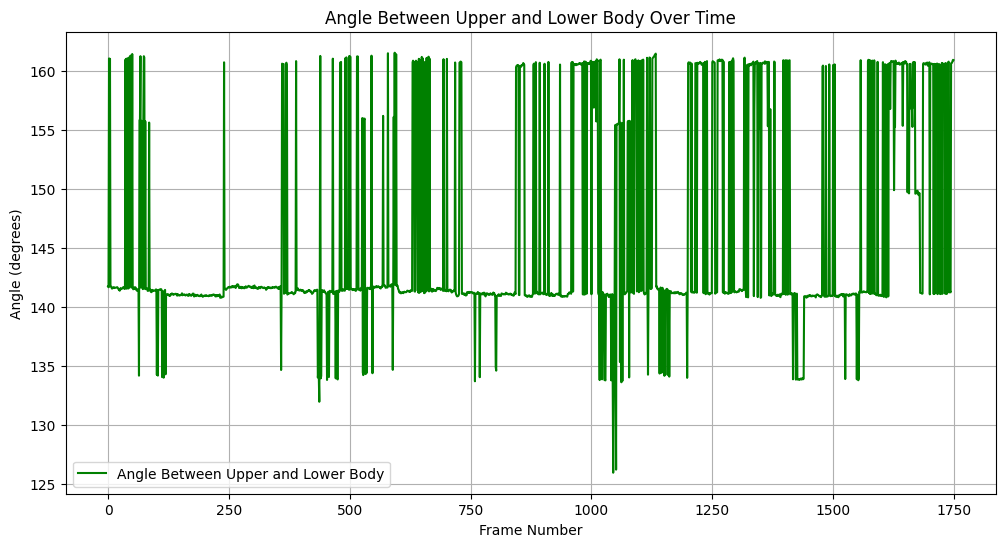

In [13]:
import matplotlib.pyplot as plt

# Plotting the angle
plt.figure(figsize=(12, 6))
plt.plot(angles_df['frame'], angles_df['angle'], label='Angle Between Upper and Lower Body', color='green')
plt.xlabel('Frame Number')
plt.ylabel('Angle (degrees)')
plt.title('Angle Between Upper and Lower Body Over Time')
plt.legend()
plt.grid(True)
plt.show()


End of video or error reading frame.


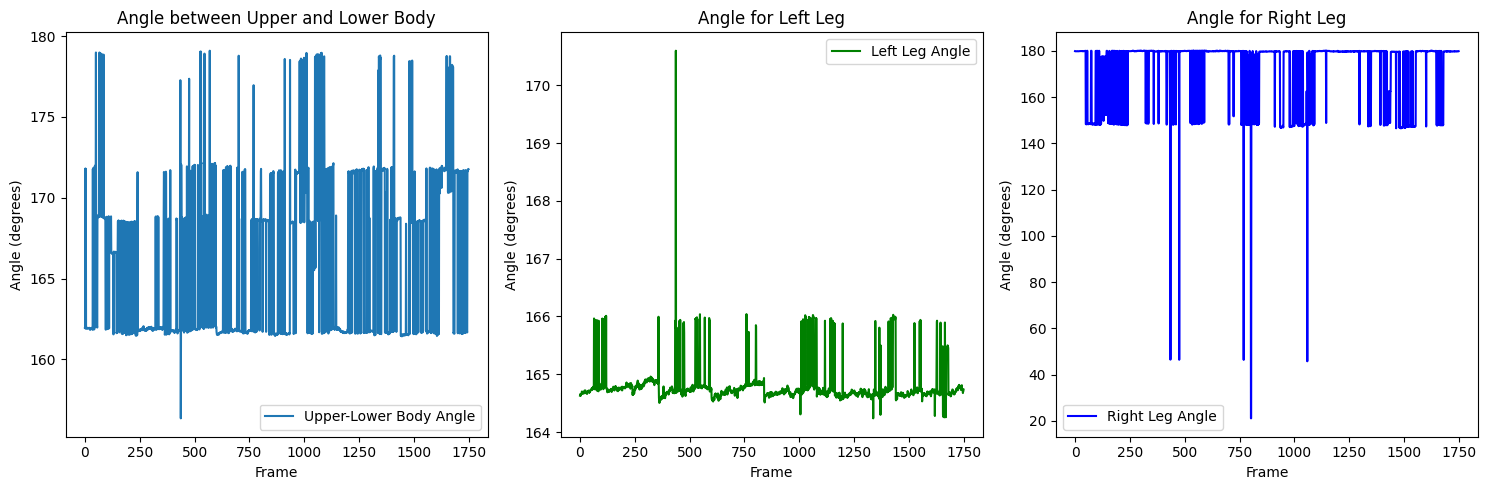

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_angle(keypoints, p1, p2, p3):
    """Calculate the angle between three keypoints."""
    # Points are indexed as (x, y, visibility)
    x1, y1, _ = keypoints[p1]
    x2, y2, _ = keypoints[p2]
    x3, y3, _ = keypoints[p3]
    
    # Vectors
    v1 = np.array([x2 - x1, y2 - y1])
    v2 = np.array([x3 - x2, y3 - y2])
    
    # Angle calculation
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    angle = np.arccos(np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)) * 180 / np.pi
    return angle

def plot_angles(landmarks_list):
    """Plot angles between different keypoints over time."""
    angles_upper_lower_body = []
    angles_left_leg = []
    angles_right_leg = []
    frames = list(range(len(landmarks_list)))
    
    for frame_data in landmarks_list:
        keypoints = frame_data['keypoints']
        
        # Example: Calculate angle between keypoints for the upper and lower body
        # Assuming the indices for upper and lower body parts; you can adjust these
        angle_upper_lower_body = calculate_angle(keypoints, 0, 5, 11)  # Example indices
        angles_upper_lower_body.append(angle_upper_lower_body)
        
        # Example: Calculate angles for legs
        angle_left_leg = calculate_angle(keypoints, 5, 6, 7)  # Example indices for left leg
        angles_left_leg.append(angle_left_leg)
        angle_right_leg = calculate_angle(keypoints, 0, 1, 2)  # Example indices for right leg
        angles_right_leg.append(angle_right_leg)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(frames, angles_upper_lower_body, label='Upper-Lower Body Angle')
    plt.xlabel('Frame')
    plt.ylabel('Angle (degrees)')
    plt.title('Angle between Upper and Lower Body')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(frames, angles_left_leg, label='Left Leg Angle', color='green')
    plt.xlabel('Frame')
    plt.ylabel('Angle (degrees)')
    plt.title('Angle for Left Leg')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(frames, angles_right_leg, label='Right Leg Angle', color='blue')
    plt.xlabel('Frame')
    plt.ylabel('Angle (degrees)')
    plt.title('Angle for Right Leg')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
video_path = r"G:\Pose AI\Input Video\WhatsApp Video 2024-09-18 at 10.22.46_d6797a9c.mp4"
landmarks_list = process_video(video_path, movenet, input_size)
plot_angles(landmarks_list)


# Comparision
